In [3]:
import torch
from torchvision import datasets, transforms,models
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torchvision
import os
import json
import random
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt    
import matplotlib.image as mpimg
import time

In [ ]:
# Import the zipfile module to handle zip archives
import zipfile

# Open the zip file 'TestDataSet.zip' in read mode and extract all its contents into the 'TestDataSet' folder
with zipfile.ZipFile('TestDataSet.zip','r') as zip_ref:
    zip_ref.extractall("TestDataSet")

# Set the device to GPU (if available), otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dict_keys(['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship', '406: altar', '407: ambulance', '408: amphibian', '409: analog clock', '410: apiary', '411: apron', '412: ashcan', '413: assault rifle', '414: backpack', '415: bakery', '416: balance beam', '417: balloon', '418: ballpoint', '419: Band Aid', '420: banjo', '421: bannister', '422: barbell', '423: barber chair', '424: barbershop', '425: barn', '426: barometer', '427: barrel', '428: barrow', '429: baseball', '430: basketball', '431: bassinet', '432: bassoon', '433: bathing cap', '434: bath towel', '435: bathtub', '436: beach wagon', '437: beacon', '438: beaker', '439: bearskin', '440: beer bottle', '441: beer glass', '442: bell cote', '443: bib', '444: bicycle-built-for-two', '445: bikini', '446: binder', '447: binoculars', '448: birdhouse', '449: boathouse', '450: bobsled', '451: bolo tie', '452: bonnet', '453: bookcase', '454: bookshop', '455: bottlecap', '456: bow', '457: bow ti

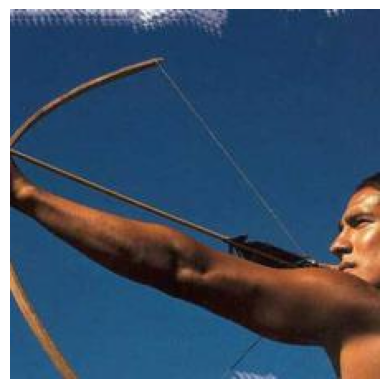

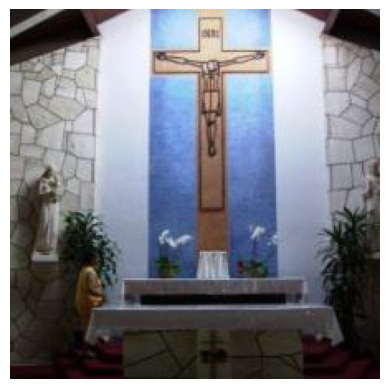

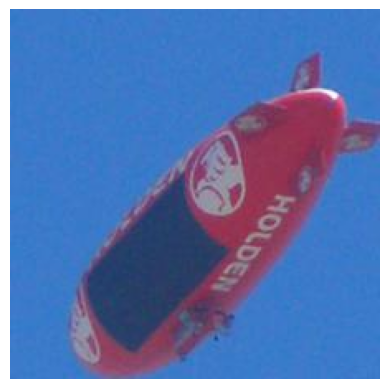

In [ ]:
# Load pretrained ResNet-34 model with ImageNet weights
pretrained_model = models.resnet34(weights='IMAGENET1K_V1')

# Define normalization values (mean and std) used during training of the model
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

# Define preprocessing pipeline: convert to tensor and normalize
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Dataset path containing the test images
dataset_path = "./TestDataSet/TestDataSet"

# Load label mapping from JSON file
with open('./TestDataSet/TestDataSet/labels_list.json') as f:
    class_map = json.load(f)

# Create a reverse map {imagenet_class_id: local_index}
New_map = {m: k for k, m in enumerate(class_map)}

# Print keys and values for debugging
print(New_map.keys())
print(New_map.values())
print(list(New_map.keys())[0])

# Initialize list to store training times (not used further here)
Train_times = []

# Load dataset using ImageFolder, applying preprocessing
dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
print(dataset.class_to_idx)

# Create DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Move pretrained model to GPU (if available)
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)

# Offset applied to match ImageNet label indices (starting from 401)
offset = 401

# Function to evaluate top-1 and top-5 accuracy
def evaluate_topk(model, dataloader, offset, device):
    model.eval()
    with torch.no_grad():
        top1_correct, top5_correct, total = 0, 0, 0
        for _, (images, labels) in enumerate(dataloader):
            x = images.to(device)
            y = labels.to(device) + offset  # Adjust labels by offset to match model output indices
            out = model(x)
            _, pred1 = out.max(dim=1)  # Top-1 prediction
            top5_preds = out.topk(5, dim=1).indices  # Top-5 predictions
            top1_correct += (pred1 == y).sum().item()
            top5_correct += top5_preds.eq(y.unsqueeze(1)).any(dim=1).sum().item()
            total += labels.size(0)
    # Compute percentage accuracy
    top1 = top1_correct / total * 100
    top5 = top5_correct / total * 100
    print(f"Top-1 Accuracy: {top1:.2f}%")
    print(f"Top-5 Accuracy: {top5:.2f}%")

# Run evaluation on the model and dataset
evaluate_topk(pretrained_model, dataloader, offset, device)

# Get total number of samples and randomly select 3 indices
index = len(dataset)
select = random.sample(range(index), k=3)

# Re-define normalization stats
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# List to store eligibility results (not used further)
eli_list = []

# Function to unnormalize image for visualization
def un_normalzied(img, mean, std):
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]
    return img

import random

# Function to visualize selected unnormalized images
def visualize_images(dataloader, select, mean, std):
    dataset = dataloader.dataset
    print(select)
    for n in range(len(select)):
        index = select[n]
        image, _ = dataset[index]

        if isinstance(image, torch.Tensor):
            image = image.squeeze().cpu().numpy()
        else:
            image = np.array(image)

        image = un_normalzied(image, mean, std)
        image = np.transpose(image, (1, 2, 0))
        image = np.clip(image, 0, 1)
        plt.figure()
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# Function to check if perturbation is within epsilon bound
def check_eli(perturbed, image, epsilon, r=1e-7):
    diff = torch.abs(perturbed - image)
    max_per_image = diff.view(diff.size(0), -1).max(dim=1).values
    epsilon_loss = epsilon + r
    if (max_per_image > epsilon_loss).any():
        return False
    else:
        return True

# Save dataloader object for reuse
torch.save(dataloader, 'dataloader.pt')

# Visualize the 3 randomly selected images
visualize_images(dataloader, select, mean, std)

ε is perfect
Adversarial_Test_Set_1
Top-1 Accuracy: 6.20%
Top-5 Accuracy: 35.60%
[279, 26, 22]


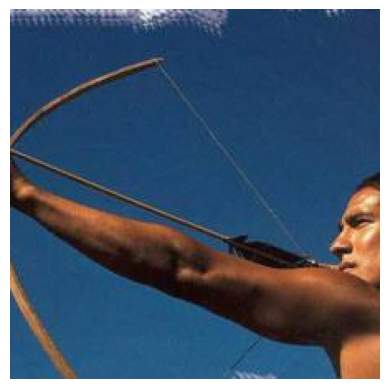

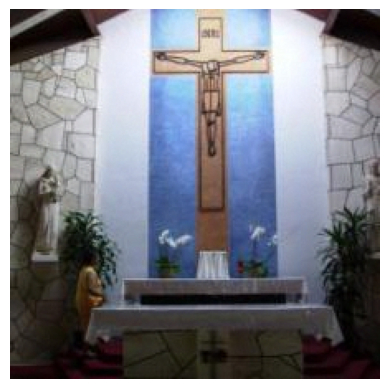

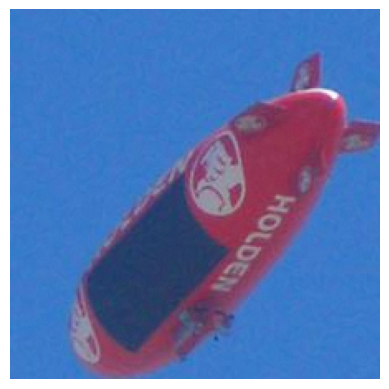

In [ ]:
# Define the Fast Gradient Sign Method (FGSM) attack
def fgsm_attack(x, epsilon, grad):
    # Generate adversarial example by adjusting input in direction of gradient sign
    return x + epsilon * grad.sign()


# Function to generate FGSM-based adversarial examples
def make_fgsm(model, dataloader, epsilon, offset, device):
    model.eval()
    Is_False = False  # Flag to check if any adversarial sample violates epsilon constraint
    images, labels = [], []  # Lists to collect adversarial images and labels
    start_time = time.perf_counter()  # Record start time for performance measurement
    L = nn.CrossEntropyLoss()  # Loss function

    for image, label in dataloader:
        image = image.to(device).requires_grad_(True)  # Enable gradient computation on input
        true_idxs = label.to(device) + offset  # Map to ImageNet label indices
        outputs = model(image)  # Forward pass
        loss = L(outputs, true_idxs)  # Compute cross-entropy loss
        loss.backward()  # Backward pass to compute gradients

        # Generate adversarial image
        perturbed = fgsm_attack(image, epsilon, image.grad)

        # Clip to keep perturbation within [x - ε, x + ε]
        perturbed = torch.max(torch.min(perturbed, image + epsilon), image - epsilon)

        # Check if perturbation stays within allowed epsilon range
        Error = check_eli(perturbed, image, epsilon)
        if Error == False:
            Is_False = True

        # Save adversarial image and label
        images.append(perturbed.detach().cpu())
        labels.append(label)

    # Print epsilon validation result
    if Is_False == False:
        print("ε is perfect")
    else:
        print("ε has error")

    end_time = time.perf_counter()  # End time for performance measurement
    total_time = end_time - start_time
    Train_times.append(total_time)  # Record time for this attack
    eli_list.append(epsilon)  # Record used epsilon value

    # Create a new dataset from generated adversarial examples
    dataset = TensorDataset(torch.cat(images), torch.cat(labels))
    return dataset

# Set the attack budget epsilon
epsilon = 0.02

# Generate adversarial test set using FGSM
Attack = make_fgsm(pretrained_model, dataloader, epsilon, offset, device)

# Create a DataLoader from the adversarial dataset
Adversarial_Test_Set_1 = DataLoader(Attack, batch_size=32, shuffle=False)

# Output and evaluate model accuracy on adversarial examples
print("Adversarial_Test_Set_1")
evaluate_topk(pretrained_model, Adversarial_Test_Set_1, offset, device)

# Visualize 3 selected adversarial samples
visualize_images(Adversarial_Test_Set_1, select, mean, std)

# Save the adversarial DataLoader for reuse
torch.save(Adversarial_Test_Set_1, 'Adversarial_Test_Set_1.pt')



ε is perfect
Adversarial_Test_Set_2
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 14.40%
[279, 26, 22]


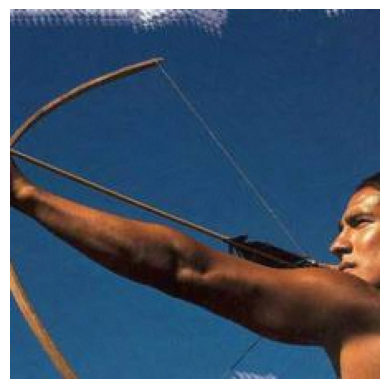

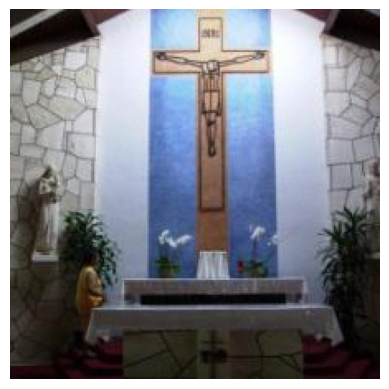

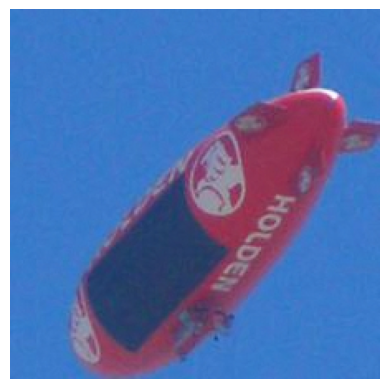

In [ ]:
# Define the PGD (Projected Gradient Descent) attack function
def pgd_attack(x, y, model, epsilon, iters):
    # Initialize perturbation delta with random noise in [-ε/4, ε/4]
    delta = torch.zeros_like(x).uniform_(-epsilon/4, epsilon/4).to(x.device)
    delta.requires_grad_(True)
    L = nn.CrossEntropyLoss()  # Define loss function

    # Iteratively refine the perturbation
    for _ in range(iters):
        outputs = model(x + delta)  # Forward pass on perturbed input
        loss = L(outputs, y)        # Compute loss with respect to true label
        loss.backward()             # Backpropagate to get gradient w.r.t delta

        # Update delta using the gradient's sign, clamp to ε-ball
        delta.data = (delta + epsilon * delta.grad.sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()  # Reset gradients for next iteration

    # Return final perturbed image
    return (x + delta).detach()


# Function to apply PGD to the entire dataset
def make_pgd(model, dataloader, epsilon, iters, offset, device):
    model.eval()  # Set model to evaluation mode
    start_time = time.perf_counter()  # Track execution time
    Is_False = False  # Flag for epsilon validity check
    images, labels = [], []  # Lists to hold perturbed images and labels

    for image, label in dataloader:
        image = image.to(device)
        true_idxs = label.to(device) + offset  # Adjust label to match model class IDs

        # Generate adversarial image using PGD
        perturbed = pgd_attack(image, true_idxs, model, epsilon, iters)

        # Clip to ensure perturbation stays within valid epsilon range
        perturbed = torch.max(torch.min(perturbed, image + epsilon), image - epsilon)

        # Validate if perturbation is within epsilon
        Error = check_eli(perturbed, image, epsilon)
        if Error == False:
            Is_False = True

        # Append results to lists
        images.append(perturbed.cpu())
        labels.append(label)

    end_time = time.perf_counter()  # Record execution end time
    total_time = end_time - start_time
    Train_times.append(total_time)  # Store total time taken
    eli_list.append(epsilon)        # Track used epsilon value

    # Print epsilon validation result
    if Is_False == False:
        print("ε is perfect")
    else:
        print("ε has error")

    # Create and return dataset from perturbed images and original labels
    return TensorDataset(torch.cat(images), torch.cat(labels))


# Set PGD parameters
epsilon, iters = 0.02, 100

# Create adversarial dataset using PGD attack
Attack2 = make_pgd(pretrained_model, dataloader, epsilon, iters, offset, device)

# Wrap the dataset into a DataLoader
Adversarial_Test_Set_2 = DataLoader(Attack2, batch_size=32, shuffle=False)

# Evaluate model performance on PGD adversarial examples
print("Adversarial_Test_Set_2")
evaluate_topk(pretrained_model, Adversarial_Test_Set_2, offset, device)

# Visualize selected adversarial examples
visualize_images(Adversarial_Test_Set_2, select, mean, std)

# Save the adversarial dataset for reuse
torch.save(Adversarial_Test_Set_2, 'Adversarial_Test_Set_2.pt')


ε is perfect
Adversarial_Test_Set_3
Top-1 Accuracy: 16.60%
Top-5 Accuracy: 58.40%
[279, 26, 22]


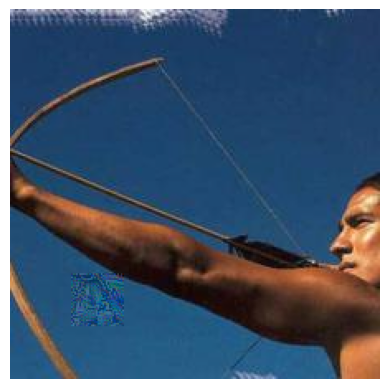

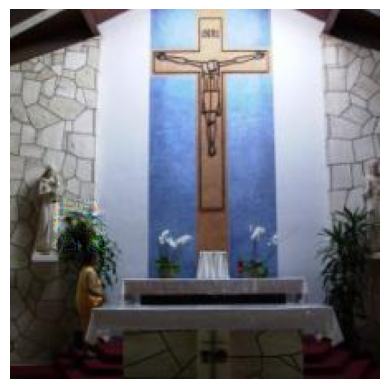

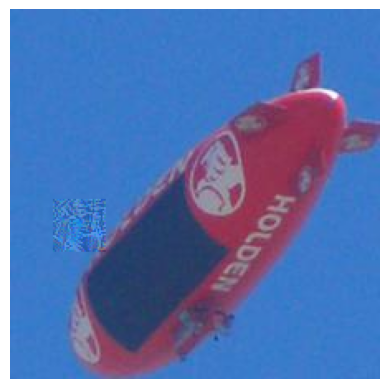

In [ ]:
# Define patch-based adversarial attack
def patch_attack(x, y, model, epsilon, patch_size, iters, S=0.1):
    L = nn.CrossEntropyLoss()  # Loss function
    delta = torch.zeros_like(x)  # Initialize perturbation tensor with zeros
    B, C, H, W = x.shape  # Get batch, channels, height, width

    # Randomly select top-left corner of the patch
    i = torch.randint(0, H - patch_size + 1, (1,)).item()
    j = torch.randint(0, W - patch_size + 1, (1,)).item()

    # Initialize patch region with uniform noise in [-ε/4, ε/4]
    delta[:, :, i:i+patch_size, j:j+patch_size] = torch.zeros((B, C, patch_size, patch_size), device=x.device).uniform_(-epsilon/4, epsilon/4)
    delta.requires_grad_(True)

    # Iteratively optimize the perturbation patch
    for _ in range(iters):
        outputs = model(x + delta)  # Forward pass
        loss = L(outputs, y)        # Compute loss
        loss.backward()             # Compute gradients

        # Update only the patch region using sign of gradients
        delta.data[:, :, i:i+patch_size, j:j+patch_size] = (
            delta[:, :, i:i+patch_size, j:j+patch_size] +
            S * epsilon * delta.grad.sign()[:, :, i:i+patch_size, j:j+patch_size]
        ).clamp(-epsilon, epsilon)  # Clip within [-ε, ε]

        delta.grad.zero_()  # Reset gradient

    # Return adversarial example
    return (x + delta).detach()


# Apply patch-based attack to entire dataset
def make_patch(model, dataloader, epsilon, patch_size, iters, offset, device):
    model.eval()  # Set model to eval mode
    start_time = time.perf_counter()  # Start timing
    Is_False = False  # Flag for epsilon constraint validation
    images, labels = [], []  # Lists to collect adversarial data

    for image, label in dataloader:
        image = image.to(device)
        true_idxs = label.to(device) + offset  # Adjust labels

        # Generate adversarial image using patch attack
        perturbed = patch_attack(image, true_idxs, model, epsilon, patch_size, iters)

        # Ensure perturbation stays within [x - ε, x + ε]
        perturbed = torch.max(torch.min(perturbed, image + epsilon), image - epsilon)

        # Check if perturbation respects ε constraint
        Error = check_eli(perturbed, image, epsilon)
        if Error == False:
            Is_False = True

        # Save adversarial image and label
        images.append(perturbed.cpu())
        labels.append(label)

    end_time = time.perf_counter()  # Stop timing
    total_time = end_time - start_time
    Train_times.append(total_time)  # Save runtime
    eli_list.append(epsilon)        # Save epsilon used

    # Print epsilon validation status
    if Is_False == False:
        print("ε is perfect")
    else:
        print("ε has error")

    # Return combined dataset of adversarial examples
    return TensorDataset(torch.cat(images), torch.cat(labels))


# Set attack parameters
epsilon, patch_size, iters = 0.5, 32, 100

# Create adversarial dataset using patch-based attack
Attack3 = make_patch(pretrained_model, dataloader, epsilon, patch_size, iters, offset, device)

# Wrap into DataLoader
Adversarial_Test_Set_3 = DataLoader(Attack3, batch_size=32, shuffle=False)

# Evaluate model on adversarial dataset
print("Adversarial_Test_Set_3")
evaluate_topk(pretrained_model, Adversarial_Test_Set_3, offset, device)

# Visualize selected adversarial samples
visualize_images(Adversarial_Test_Set_3, select, mean, std)

# Save adversarial dataset
torch.save(Adversarial_Test_Set_3, 'Adversarial_Test_Set_3.pt')


In [ ]:
# Load a pretrained DenseNet-121 model with ImageNet weights
transfer_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1).to(device)

# List of dataset names for display
List_name = ["Original", "FGSM", "PGD", "Patch"]

# Corresponding saved DataLoader filenames
List_data = ["dataloader", "Adversarial_Test_Set_1", "Adversarial_Test_Set_2", "Adversarial_Test_Set_3"]

# Loop through each dataset and evaluate on both ResNet34 and DenseNet121
for i in range(4):
    dataset = torch.load(f"{List_data[i]}.pt")  # Load dataset from file
    print(f"\n{List_name[i]} on resnet34")
    evaluate_topk(pretrained_model, dataset, offset, device)  # Evaluate using ResNet34
    print(f"\n{List_name[i]} on densenet121")
    evaluate_topk(transfer_model, dataset, offset, device)    # Evaluate using DenseNet121

# Print training time for each adversarial attack
for i in range(3):
    print(f"\nTraining adversarial test set time")
    print(f"{List_data[i+1]} with {eli_list[i]} need {Train_times[i]}")


C:\Users\26435\AppData\Local\Temp\ipykernel_4936\4019940954.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(f"{List_data[i]}.pt")



Original on resnet34
Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%

Original on densenet121
Top-1 Accuracy: 74.60%
Top-5 Accuracy: 93.60%

FGSM on resnet34
Top-1 Accuracy: 6.20%
Top-5 Accuracy: 36.00%

FGSM on densenet121
Top-1 Accuracy: 63.40%
Top-5 Accuracy: 89.00%

PGD on resnet34
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 15.00%

PGD on densenet121
Top-1 Accuracy: 65.80%
Top-5 Accuracy: 91.00%

Patch on resnet34
Top-1 Accuracy: 16.40%
Top-5 Accuracy: 58.40%

Patch on densenet121
Top-1 Accuracy: 70.00%
Top-5 Accuracy: 91.20%

Training adversarial test set time
Adversarial_Test_Set_1 with 0.02 need 1.8232128000017838

Training adversarial test set time
Adversarial_Test_Set_2 with 0.02 need 122.5129080000006

Training adversarial test set time
Adversarial_Test_Set_3 with 0.5 need 120.94776690000072
